<img src="../images/QVP.svg" width=800 alt="QVP plot"></img>

# QPE & QVPs

---

## Overview
In this notebook, we demonstrate how utilizing radar data in the Analysis-Ready Cloud-Optimized (ARCO) format enables efficient computation of Quantitative Precipitation Estimates (QPE) and Quasi-Vertical Profiles (QVP). The ARCO format ensures that radar data is pre-processed, clean, and well-organized, significantly reducing the time spent on data preparation and cleaning. By leveraging ARCO radar data, we can focus more on scientific analysis.
1. QPE Demo
2. QVP Demo

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary |  Basic features |
| [Radar Cookbook](https://projectpythia.org/radar-cookbook/README.html) | Necessary |  Radar basics |
|[Intro to Zarr](https://zarr.readthedocs.io/en/stable/tutorial.html)| Necessary | Zarr basics

- **Time to learn**: 45 minutes

---

## Imports

In [1]:
import s3fs
import xarray as xr
import fsspec
import numpy as np
import hvplot.xarray
import matplotlib.pyplot as plt

## ARCO radar dataset

We build a dataset (object storage) containing both X and C-band radar data. This dataset is located at the Pythia S3 Bucket.

In [2]:
## S3 bucket connection
URL = 'https://js2.jetstream-cloud.org:8001/'
path = f'pythia/radar/erad2024'
fs = s3fs.S3FileSystem(anon=True, client_kwargs=dict(endpoint_url=URL))
file =  s3fs.S3Map(f"{path}/zarr_radar/erad_2024.zarr", s3=fs)

Let's read our ARCO dataset using `xr.backends.api.open_datatree`

In [3]:
%%time
dtree = xr.backends.api.open_datatree(
    file, 
    engine='zarr', 
    consolidated=True, 
    chunks={}
)

CPU times: user 3.18 s, sys: 293 ms, total: 3.48 s
Wall time: 15 s


In [4]:
dtree

<xarray.DataTree>
Group: /
├── Group: /cband
│   ├── Group: /cband/sweep_0
│   │       Dimensions:                              (volume_time: 73, azimuth: 360,
│   │                                                 range: 492)
│   │       Coordinates:
│   │           altitude                             float32 4B ...
│   │         * azimuth                              (azimuth) float32 1kB 0.5 1.5 ... 359.5
│   │           crs_wkt                              int64 8B ...
│   │           elevation                            (volume_time, azimuth) float32 105kB dask.array<chunksize=(73, 360), meta=np.ndarray>
│   │           latitude                             float32 4B ...
│   │           longitude                            float32 4B ...
│   │         * range                                (range) float32 2kB 250.0 ... 2.457e+05
│   │           time                                 (volume_time, azimuth) datetime64[ns] 210kB dask.array<chunksize=(73, 360), meta=np.ndarray>
│   │         * volume_time                          (volume_time) datetime64[ns] 584B 20...
│   │           x                                    (azimuth, range, volume_time) float32 52MB dask.array<chunksize=(90, 123, 19), meta=np.ndarray>
│   │           y                                    (azimuth, range, volume_time) float32 52MB dask.array<chunksize=(90, 123, 19), meta=np.ndarray>
│   │           z                                    (volume_time, azimuth, range) float32 52MB dask.array<chunksize=(19, 90, 123), meta=np.ndarray>
│   │       Data variables: (12/14)
│   │           differential_reflectivity            (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│   │           nyquist_velocity                     (volume_time, azimuth) float32 105kB dask.array<chunksize=(1, 360), meta=np.ndarray>
│   │           pulse_width                          (volume_time, azimuth) timedelta64[ns] 210kB dask.array<chunksize=(1, 360), meta=np.ndarray>
│   │           reflectivity                         (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│   │           reflectivity_hh_clut                 (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│   │           reflectivity_vv                      (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│   │           ...                                   ...
│   │           sweep_fixed_angle                    (volume_time) float32 292B dask.array<chunksize=(73,), meta=np.ndarray>
│   │           sweep_mode                           (volume_time) <U20 6kB dask.array<chunksize=(73,), meta=np.ndarray>
│   │           sweep_number                         (volume_time) int64 584B dask.array<chunksize=(73,), meta=np.ndarray>
│   │           uncorrected_cross_correlation_ratio  (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│   │           uncorrected_differential_phase       (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│   │           velocity                             (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│   ├── Group: /cband/sweep_1
│   │       Dimensions:                              (volume_time: 73, azimuth: 360,
│   │                                                 range: 492)
│   │       Coordinates:
│   │           altitude                             float32 4B ...
│   │         * azimuth                              (azimuth) float32 1kB 0.5 1.5 ... 359.5
│   │           crs_wkt                              int64 8B ...
│   │           elevation                            (volume_time, azimuth) float32 105kB dask.array<chunksize=(73, 360), meta=np.ndarray>
│   │           latitude                             float32 4B ...
│   │           longitude      

In [5]:
list(dtree.children)

['cband', 'xband']

### C-band radar data

We can access a nested dataset by using the path as follows:

In [6]:
dtree["cband"]

<xarray.DataTree 'cband'>
Group: /cband
├── Group: /cband/sweep_0
│       Dimensions:                              (volume_time: 73, azimuth: 360,
│                                                 range: 492)
│       Coordinates:
│           altitude                             float32 4B ...
│         * azimuth                              (azimuth) float32 1kB 0.5 1.5 ... 359.5
│           crs_wkt                              int64 8B ...
│           elevation                            (volume_time, azimuth) float32 105kB dask.array<chunksize=(73, 360), meta=np.ndarray>
│           latitude                             float32 4B ...
│           longitude                            float32 4B ...
│         * range                                (range) float32 2kB 250.0 ... 2.457e+05
│           time                                 (volume_time, azimuth) datetime64[ns] 210kB dask.array<chunksize=(73, 360), meta=np.ndarray>
│         * volume_time                          (volume_time) datetime64[ns] 584B 20...
│           x                                    (azimuth, range, volume_time) float32 52MB dask.array<chunksize=(90, 123, 19), meta=np.ndarray>
│           y                                    (azimuth, range, volume_time) float32 52MB dask.array<chunksize=(90, 123, 19), meta=np.ndarray>
│           z                                    (volume_time, azimuth, range) float32 52MB dask.array<chunksize=(19, 90, 123), meta=np.ndarray>
│       Data variables: (12/14)
│           differential_reflectivity            (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│           nyquist_velocity                     (volume_time, azimuth) float32 105kB dask.array<chunksize=(1, 360), meta=np.ndarray>
│           pulse_width                          (volume_time, azimuth) timedelta64[ns] 210kB dask.array<chunksize=(1, 360), meta=np.ndarray>
│           reflectivity                         (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│           reflectivity_hh_clut                 (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│           reflectivity_vv                      (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│           ...                                   ...
│           sweep_fixed_angle                    (volume_time) float32 292B dask.array<chunksize=(73,), meta=np.ndarray>
│           sweep_mode                           (volume_time) <U20 6kB dask.array<chunksize=(73,), meta=np.ndarray>
│           sweep_number                         (volume_time) int64 584B dask.array<chunksize=(73,), meta=np.ndarray>
│           uncorrected_cross_correlation_ratio  (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│           uncorrected_differential_phase       (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
│           velocity                             (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
├── Group: /cband/sweep_1
│       Dimensions:                              (volume_time: 73, azimuth: 360,
│                                                 range: 492)
│       Coordinates:
│           altitude                             float32 4B ...
│         * azimuth                              (azimuth) float32 1kB 0.5 1.5 ... 359.5
│           crs_wkt                              int64 8B ...
│           elevation                            (volume_time, azimuth) float32 105kB dask.array<chunksize=(73, 360), meta=np.ndarray>
│           latitude                             float32 4B ...
│           longitude                            float32 4B ...
│         * range                                (range) float32 2kB 250.0 ... 2.457e+05
│           time                       

In [7]:
# all sweeps/nodes within the cband datatree
list(dtree["cband"].children)

['sweep_0',
 'sweep_1',
 'sweep_10',
 'sweep_11',
 'sweep_12',
 'sweep_13',
 'sweep_14',
 'sweep_15',
 'sweep_16',
 'sweep_17',
 'sweep_18',
 'sweep_19',
 'sweep_2',
 'sweep_3',
 'sweep_4',
 'sweep_5',
 'sweep_6',
 'sweep_7',
 'sweep_8',
 'sweep_9']

Accessing one of the sweeps ("sweep_2"):

In [8]:
dsc = dtree["cband/sweep_2"].ds

In [9]:
display(dsc)

<xarray.DatasetView> Size: 1GB
Dimensions:                              (volume_time: 73, azimuth: 360,
                                          range: 492)
Coordinates:
    altitude                             float32 4B ...
  * azimuth                              (azimuth) float32 1kB 0.5 1.5 ... 359.5
    crs_wkt                              int64 8B ...
    elevation                            (volume_time, azimuth) float32 105kB dask.array<chunksize=(73, 360), meta=np.ndarray>
    latitude                             float32 4B ...
    longitude                            float32 4B ...
  * range                                (range) float32 2kB 250.0 ... 2.457e+05
    time                                 (volume_time, azimuth) datetime64[ns] 210kB dask.array<chunksize=(73, 360), meta=np.ndarray>
  * volume_time                          (volume_time) datetime64[ns] 584B 20...
    x                                    (azimuth, range, volume_time) float32 52MB dask.array<chunksize=(90, 123, 19), meta=np.ndarray>
    y                                    (azimuth, range, volume_time) float32 52MB dask.array<chunksize=(90, 123, 19), meta=np.ndarray>
    z                                    (volume_time, azimuth, range) float32 52MB dask.array<chunksize=(19, 90, 123), meta=np.ndarray>
Data variables: (12/14)
    differential_reflectivity            (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    nyquist_velocity                     (volume_time, azimuth) float32 105kB dask.array<chunksize=(1, 360), meta=np.ndarray>
    pulse_width                          (volume_time, azimuth) timedelta64[ns] 210kB dask.array<chunksize=(1, 360), meta=np.ndarray>
    reflectivity                         (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    reflectivity_hh_clut                 (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    reflectivity_vv                      (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    ...                                   ...
    sweep_fixed_angle                    (volume_time) float32 292B dask.array<chunksize=(73,), meta=np.ndarray>
    sweep_mode                           (volume_time) <U20 6kB dask.array<chunksize=(73,), meta=np.ndarray>
    sweep_number                         (volume_time) int64 584B dask.array<chunksize=(73,), meta=np.ndarray>
    uncorrected_cross_correlation_ratio  (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    uncorrected_differential_phase       (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>
    velocity                             (volume_time, azimuth, range) float64 103MB dask.array<chunksize=(1, 360, 492), meta=np.ndarray>

### X-band radar data

Similarly, we can access X-band radar data as follows:

In [10]:
list(dtree["xband"].children)

['sweep_0',
 'sweep_1',
 'sweep_2',
 'sweep_3',
 'sweep_4',
 'sweep_5',
 'sweep_6',
 'sweep_7']

In [11]:
dsx = dtree["xband/sweep_0"].ds

In [12]:
display(dsx)

<xarray.DatasetView> Size: 1GB
Dimensions:                    (volume_time: 72, azimuth: 360, range: 416)
Coordinates:
    altitude                   float64 8B ...
  * azimuth                    (azimuth) float32 1kB 0.5 1.5 2.5 ... 358.5 359.5
    crs_wkt                    int64 8B ...
    elevation                  (volume_time, azimuth) float32 104kB dask.array<chunksize=(72, 360), meta=np.ndarray>
    latitude                   float64 8B ...
    longitude                  float64 8B ...
  * range                      (range) float32 2kB 150.0 450.0 ... 1.246e+05
    time                       (volume_time, azimuth, range) datetime64[ns] 86MB dask.array<chunksize=(18, 90, 104), meta=np.ndarray>
  * volume_time                (volume_time) datetime64[ns] 576B 2024-05-22T1...
    x                          (azimuth, range, volume_time) float32 43MB dask.array<chunksize=(90, 104, 18), meta=np.ndarray>
    y                          (azimuth, range, volume_time) float32 43MB dask.array<chunksize=(90, 104, 18), meta=np.ndarray>
    z                          (volume_time, azimuth, range) float32 43MB dask.array<chunksize=(18, 90, 104), meta=np.ndarray>
Data variables: (12/30)
    DBZ                        (volume_time, azimuth, range) float64 86MB dask.array<chunksize=(1, 360, 416), meta=np.ndarray>
    DBZ_TOT                    (volume_time, azimuth, range) float64 86MB dask.array<chunksize=(1, 360, 416), meta=np.ndarray>
    HCLASS                     (volume_time, azimuth, range) float64 86MB dask.array<chunksize=(1, 360, 416), meta=np.ndarray>
    KDP                        (volume_time, azimuth, range) float64 86MB dask.array<chunksize=(1, 360, 416), meta=np.ndarray>
    MCSSX                      (volume_time, azimuth, range) float32 43MB dask.array<chunksize=(1, 360, 416), meta=np.ndarray>
    PHIDP                      (volume_time, azimuth, range) float64 86MB dask.array<chunksize=(1, 360, 416), meta=np.ndarray>
    ...                         ...
    ray_start_range            (volume_time, azimuth) float32 104kB dask.array<chunksize=(1, 360), meta=np.ndarray>
    scan_rate                  (volume_time, azimuth) float32 104kB dask.array<chunksize=(1, 360), meta=np.ndarray>
    sweep_fixed_angle          (volume_time) float32 288B dask.array<chunksize=(72,), meta=np.ndarray>
    sweep_mode                 (volume_time) <U20 6kB dask.array<chunksize=(72,), meta=np.ndarray>
    sweep_number               (volume_time) float64 576B dask.array<chunksize=(72,), meta=np.ndarray>
    unambiguous_range          (volume_time, azimuth) float32 104kB dask.array<chunksize=(1, 360), meta=np.ndarray>

## Quantitave Precipitation Estimation (QPE)

QPE is a critical process in meteorology, providing measurements of rainfall intensity and accumulation from radar data. One of the foundational methods for QPE is based on the  Z-R relationship, which establishes a statistical relationship between radar reflectivity (Z) and rainfall rate (R). This empirical relationship, derived from observations, is commonly expressed as 

$$𝑍=\alpha R^{\beta}$$

where $\alpha$ and $\beta$ are constants.

In [13]:
def rain_depth(z: xr.DataArray, a: float=200.0, b: float=1.6, t:int=5) -> xr.DataArray:
    """
    Estimates rainfall depth using radar reflectivity and a Z-R relationship.
    
    This function computes Quantitative Precipitation Estimation (QPE) by converting
    radar reflectivity (Z) into rainfall rate (R) using the Z-R relationship and
    then integrating over time to estimate the total rainfall depth.
    
    Parameters:
    -----------
    z : xr.DataArray
        Radar reflectivity in dBZ. This should be a multi-dimensional Xarray DataArray.
    a : float, optional
        The alpha (a) parameter in the Z-R relationship. Default is 200.0, corresponding
        to the Marshall and Palmer (1948) relationship.
    b : float, optional
        The beta (b) parameter in the Z-R relationship. Default is 1.6, also from the
        Marshall and Palmer (1948) relationship.
    t : int, optional
        Time integration period in minutes, used to convert rainfall rates into
        accumulated depth. Default is 5 minutes.
    
    Returns:
    --------
    xr.DataArray
        A DataArray representing the estimated rainfall depth in the same dimensions
        as the input radar reflectivity. The units of the returned DataArray will be
        consistent with the time integration provided (e.g., mm for 5-minute accumulation).
    
    Notes:
    ------
    - The Z-R relationship used is of the form Z = a * R^b, where Z is in linear units.
    - The function first converts the radar reflectivity from dBZ to linear units (Z),
      then computes the rainfall rate (R), and finally multiplies by the time integration
      period to obtain the rainfall depth.
    
    Example:
    --------
    To compute the rainfall depth over a 5-minute period using reflectivity data:
    
    >>> rainfall_depth = rain_depth(z, a=200.0, b=1.6, t=5)
    
    This will return the estimated rainfall depth in millimeters, assuming the default
    parameters for the Marshall and Palmer (1955) Z-R relationship.
    
    """
    # Convert reflectivity from dBZ to linear units
    z_lin = 10 ** (z / 10) 
    # Compute rainfall depth using the Z-R relationship and time integration
    
    return ((1 / a) ** (1 / b) * z_lin ** (1 / b)) * (t / 60) # rainfall depth

Let's apply this fucntion to our radar dataset

In [14]:
r_depth = rain_depth(dsc.reflectivity)

In [15]:
r_depth

<xarray.DataArray 'reflectivity' (volume_time: 73, azimuth: 360, range: 492)> Size: 103MB
dask.array<mul, shape=(73, 360, 492), dtype=float64, chunksize=(1, 360, 492), chunktype=numpy.ndarray>
Coordinates:
    altitude     float32 4B ...
  * azimuth      (azimuth) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    crs_wkt      int64 8B ...
    elevation    (volume_time, azimuth) float32 105kB dask.array<chunksize=(73, 360), meta=np.ndarray>
    latitude     float32 4B ...
    longitude    float32 4B ...
  * range        (range) float32 2kB 250.0 750.0 ... 2.452e+05 2.457e+05
    time         (volume_time, azimuth) datetime64[ns] 210kB dask.array<chunksize=(73, 360), meta=np.ndarray>
  * volume_time  (volume_time) datetime64[ns] 584B 2024-05-22T12:55:24 ... 20...
    x            (azimuth, range, volume_time) float32 52MB dask.array<chunksize=(90, 123, 19), meta=np.ndarray>
    y            (azimuth, range, volume_time) float32 52MB dask.array<chunksize=(90, 123, 19), meta=np.ndarray>
    z            (volume_time, azimuth, range) float32 52MB dask.array<chunksize=(19, 90, 123), meta=np.ndarray>

As the coordinates depend on the `volume_time` dimension, they will disappear when aggregating along this dimension. Therefore, we need to store these coordinates so that we can add them back to our `xr.DataArray`

In [16]:
x = dsc.x.isel(volume_time=0)
y = dsc.y.isel(volume_time=0)
z = dsc.z.isel(volume_time=0)

Let's compute the total rainfall depth across the entire dataset.

In [17]:
r_total = r_depth.sum("volume_time")

Adding coordinates back

In [18]:
r_total = r_total.assign_coords({"x":x, "y":y, "z":z})

Plotting the total rainfall depth

CPU times: user 1.04 s, sys: 55.3 ms, total: 1.09 s
Wall time: 2.67 s


Text(0.5, 1.0, '')

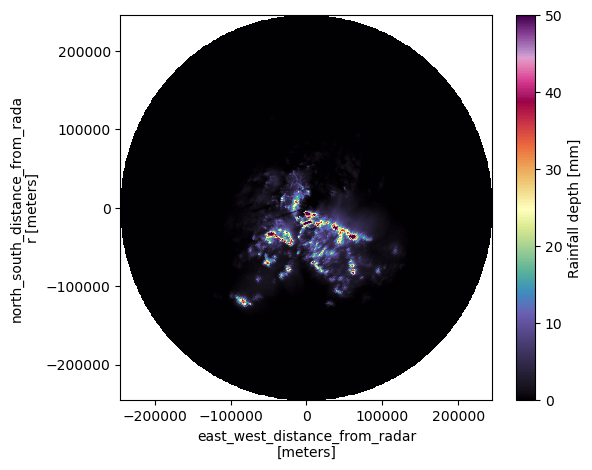

In [19]:
%%time
fig, ax = plt.subplots(figsize=(6, 5))
c = r_total.plot.pcolormesh(
    x='x', 
    y='y', 
    cmap='ChaseSpectral', 
    vmin=0,
    vmax=50,
    add_colorbar=False
)
plt.colorbar(c, ax=ax, label="Rainfall depth [mm]")
ax.set_title("")

Now it's your turn. Try computing the QPE for the X-band radar dataset

In [20]:
# Computing rainfall depth


In [21]:
# saving coordinates


In [22]:
# Acummulating rainfall depths


In [23]:
# adding back x,y, and z coordinates


In [24]:
# Plotting rainfall accumulation


## Quasi-Vertical Profile (QVP)

Quasi-Vertical Profiles (QVP) are a radar analysis technique that provides vertical profiles of atmospheric phenomena by averaging radar data over a specific azimuthal range. This method simplifies the study of storm structures, revealing vertical distributions of reflectivity, velocity, and other key parameters. QVPs are valuable for understanding storm dynamics and the development of severe weather.

The following function will help us computing QVPs

In [25]:
def compute_qvp(ds: xr.Dataset, var="reflectivity")-> xr.DataArray:
    """
    Computes a Quasi-Vertical Profile (QVP) from a radar time-series dataset.
    
    This function averages the specified variable over the azimuthal dimension
    to produce a QVP. If the variable is in dBZ (a logarithmic scale), it converts
    the values to linear units before averaging and then converts the result 
    back to dBZ.
    
    Parameters:
    -----------
    ds : xr.Dataset
        The Xarray Dataset containing the radar data. This dataset should include
        multiple sweeps, azimuth angles, and range gates.
    var : str, optional
        The variable to be averaged to create the QVP. 
        Default is "reflectivity".
    
    Returns:
    --------
    xr.DataArray
        A DataArray representing the QVP for the specified variable. The result
        is averaged over azimuth and adjusted for height using the mean sweep 
        elevation angle.
    
    Notes:
    ------
    - If the variable is in dBZ units, the function converts it to linear units 
      before averaging to ensure accurate results, then converts it back to dBZ.
    - The QVP is calculated by adjusting the range gates to height using the 
      sine of the mean sweep elevation angle.
    
    Example:
    --------
    To compute a QVP for reflectivity:
    
    >>> qvp_reflectivity = compute_qvp(ds, var="reflectivity")
    
    The resulting QVP will be in dBZ and aligned along the height dimension.
    
    """
    
    units: str = ds[var].attrs['units']
    if units.startswith("dB"):
        qvp = 10 ** (ds[var] / 10)
        qvp = qvp.mean("azimuth")
        qvp = 10 * np.log10(qvp)
    else:
        qvp = ds[var]
        qvp = qvp.mean("azimuth")
        
    qvp = qvp.assign_coords({"range":(qvp.range.values * 
                                 np.sin(ds.sweep_fixed_angle.values.mean() *  
                                        np.pi / 180.))})
    qvp = qvp.rename(f"qvp_{var}")
    qvp = qvp.rename({"range": "height"})
    return qvp

Let's compute the QVP for the X-band radar dataset at the highest elevation angle ("sweep_7").

In [26]:
ds_x = dtree["xband/sweep_7"].ds

In [27]:
display(ds_x)

<xarray.DatasetView> Size: 393MB
Dimensions:                    (volume_time: 72, azimuth: 360, range: 157)
Coordinates:
    altitude                   float64 8B ...
  * azimuth                    (azimuth) float32 1kB 0.5 1.5 2.5 ... 358.5 359.5
    crs_wkt                    int64 8B ...
    elevation                  (volume_time, azimuth) float32 104kB dask.array<chunksize=(72, 360), meta=np.ndarray>
    latitude                   float64 8B ...
    longitude                  float64 8B ...
  * range                      (range) float32 628B 150.0 450.0 ... 4.695e+04
    time                       (volume_time, azimuth, range) datetime64[ns] 33MB dask.array<chunksize=(18, 90, 79), meta=np.ndarray>
  * volume_time                (volume_time) datetime64[ns] 576B 2024-05-22T1...
    x                          (azimuth, range, volume_time) float32 16MB dask.array<chunksize=(90, 40, 36), meta=np.ndarray>
    y                          (azimuth, range, volume_time) float32 16MB dask.array<chunksize=(90, 40, 36), meta=np.ndarray>
    z                          (volume_time, azimuth, range) float32 16MB dask.array<chunksize=(18, 90, 79), meta=np.ndarray>
Data variables: (12/30)
    DBZ                        (volume_time, azimuth, range) float64 33MB dask.array<chunksize=(1, 360, 157), meta=np.ndarray>
    DBZ_TOT                    (volume_time, azimuth, range) float64 33MB dask.array<chunksize=(1, 360, 157), meta=np.ndarray>
    HCLASS                     (volume_time, azimuth, range) float64 33MB dask.array<chunksize=(1, 360, 157), meta=np.ndarray>
    KDP                        (volume_time, azimuth, range) float64 33MB dask.array<chunksize=(1, 360, 157), meta=np.ndarray>
    MCSSX                      (volume_time, azimuth, range) float32 16MB dask.array<chunksize=(1, 360, 157), meta=np.ndarray>
    PHIDP                      (volume_time, azimuth, range) float64 33MB dask.array<chunksize=(1, 360, 157), meta=np.ndarray>
    ...                         ...
    ray_start_range            (volume_time, azimuth) float32 104kB dask.array<chunksize=(1, 360), meta=np.ndarray>
    scan_rate                  (volume_time, azimuth) float32 104kB dask.array<chunksize=(1, 360), meta=np.ndarray>
    sweep_fixed_angle          (volume_time) float32 288B dask.array<chunksize=(72,), meta=np.ndarray>
    sweep_mode                 (volume_time) <U20 6kB dask.array<chunksize=(72,), meta=np.ndarray>
    sweep_number               (volume_time) float64 576B dask.array<chunksize=(72,), meta=np.ndarray>
    unambiguous_range          (volume_time, azimuth) float32 104kB dask.array<chunksize=(1, 360), meta=np.ndarray>

We can use our `compute_qvp` function to create the reflectivity QVP.

In [28]:
qvp_ref = compute_qvp(ds_x, var="DBZ")

In [29]:
display(qvp_ref)

<xarray.DataArray 'qvp_DBZ' (volume_time: 72, height: 157)> Size: 90kB
dask.array<mul, shape=(72, 157), dtype=float64, chunksize=(1, 157), chunktype=numpy.ndarray>
Coordinates:
    altitude     float64 8B ...
    crs_wkt      int64 8B ...
    latitude     float64 8B ...
    longitude    float64 8B ...
  * volume_time  (volume_time) datetime64[ns] 576B 2024-05-22T13:03:09.983000...
  * height       (height) float32 628B 63.39 190.2 317.0 ... 1.972e+04 1.984e+04

We can visualize the QVP results using the `.plot` functionality within `xarray` library.

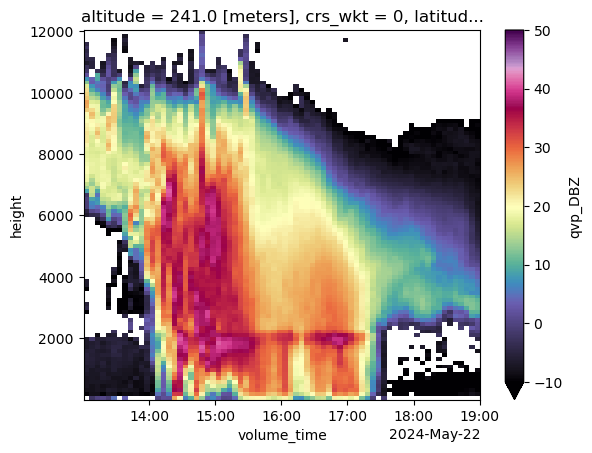

In [30]:
qvp_ref.sel(height=slice(0, 1.2e4)).plot(
    x="volume_time",
    y="height",
    cmap="ChaseSpectral",
    vmin=-10,
    vmax=50
)

Let's try to create a figure similar to the one in [Ryzhkov et al. (2016)](https://doi.org/10.1175/JTECH-D-15-0020.1) by estimating the QVP for differential reflectivity (ZDR), the cross-correlation coefficient (RHOHV), and the differential phase (PHIDP).

In [31]:
qvp_zdr = compute_qvp(ds_x, var="ZDR")
qvp_rhohv = compute_qvp(ds_x, var="RHOHV")
qvp_phidp = compute_qvp(ds_x, var="PHIDP")

Let's create the figure

CPU times: user 3.14 s, sys: 208 ms, total: 3.35 s
Wall time: 9.58 s


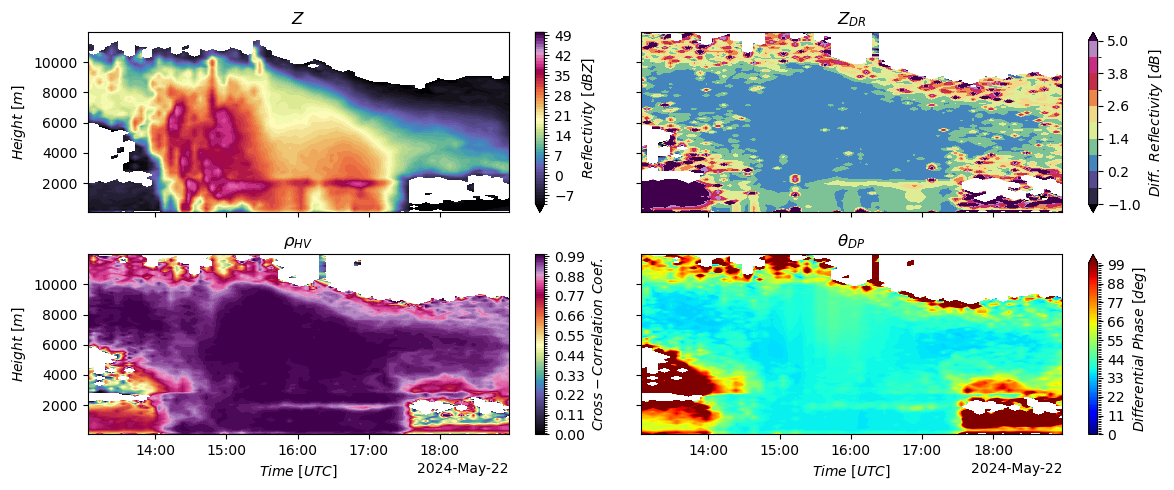

In [32]:
%%time
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharey=True, sharex=True)

cf = qvp_ref.sel(height=slice(0, 1.2e4)).plot.contourf(
    x="volume_time",
    y="height",
    cmap="ChaseSpectral",
    vmin=-10,
    vmax=50, 
    ax=axs[0][0],
    levels=np.linspace(-10, 50, 61),
    add_colorbar=False,
)
axs[0][0].set_title(r"$Z$")
axs[0][0].set_xlabel("")
axs[0][0].set_ylabel(r"$Height \ [m]$")

cbar = plt.colorbar(cf, ax=axs[0][0], 
                    label=r"$Reflectivity \ [dBZ]$", 
                   )


cf1 = qvp_zdr.sel(height=slice(0, 1.2e4)).plot.contourf(
    x="volume_time",
    y="height",
    cmap="ChaseSpectral",
    vmin=-1,
    vmax=5, 
    ax=axs[0][1],
    levels=np.linspace(-1, 5, 11),
    add_colorbar=False,
)
axs[0][1].set_title(r"$Z_{DR}$")
axs[0][1].set_xlabel("")
axs[0][1].set_ylabel(r"")

cbar = plt.colorbar(cf1, ax=axs[0][1], 
                    label=r"$Diff. \ Reflectivity \ [dB]$", 
                   )

cf2 = qvp_rhohv.sel(height=slice(0, 1.2e4)).plot.contourf(
    x="volume_time",
    y="height",
    cmap="ChaseSpectral",
    vmin=0,
    vmax=1, 
    ax=axs[1][0],
    levels=np.linspace(0, 1, 101),
    add_colorbar=False,
)
axs[1][0].set_title(r"$\rho _{HV}$")
axs[1][0].set_ylabel(r"$Height \ [m]$")
axs[1][0].set_xlabel(r"$Time \ [UTC]$")

cbar = plt.colorbar(cf2, ax=axs[1][0], 
                    label=r"$Cross-Correlation \ Coef.$", 
                   )
cf3 = qvp_phidp.sel(height=slice(0, 1.2e4)).plot.contourf(
    x="volume_time",
    y="height",
    cmap="jet",
    vmin=0,
    vmax=100, 
    ax=axs[1][1],
    levels=np.linspace(0, 100, 101),
    add_colorbar=False,

)
axs[1][1].set_title(r"$\theta _{DP}$")
axs[1][1].set_xlabel(r"$Time \ [UTC]$")
axs[1][1].set_ylabel(r"")

cbar = plt.colorbar(cf3, ax=axs[1][1], 
                    label=r"$Differential \ Phase \ [deg]$", 
                   )

fig.tight_layout()
plt.savefig('../images/QVP.svg',  bbox_inches='tight')

Now it's your turn. Try computing the QPE for the C-band radar dataset using the 20 deg elevation angle ("sweep_15")

In [33]:
## Select the sweep_15 from the dtree


In [34]:
## compute the QVP for "reflectivity", "differential_reflectivity", 
## "uncorrected_cross_correlation_ratio", and "uncorrected_differential_phase"


In [35]:
# create the figure



---

## Summary
In this notebook, we successfully computed Quantitative Precipitation Estimation (QPE) and Quasi-Vertical Profiles (QVP) for both X-band and C-band radar data using the Analysis-Ready Cloud-Optimized (ARCO) dataset. By leveraging the ARCO format, we were able to streamline the data processing, allowing us to efficiently apply our custom functions for QPE and QVP computation. This approach demonstrated the effectiveness of ARCO datasets in facilitating advanced radar data analysis with minimal preprocessing effort.


## Resources and references
 - Ryzhkov, A., P. Zhang, H. Reeves, M. Kumjian, T. Tschallener, S. Trömel, and C. Simmer, 2016: Quasi-Vertical Profiles—A New Way to Look at Polarimetric Radar Data. J. Atmos.   Oceanic Technol., 33, 551–562, https://doi.org/10.1175/JTECH-D-15-0020.1
 -  Marshall, J. S.; Palmer, W. M. (1948). "The distribution of raindrops with size". Journal of Meteorology. 5 (4): 165–166. https://doi.org/10.1175/1520-0469(1948)005%3C0165:TDORWS%3E2.0.CO;2 
 - [Xradar](https://docs.openradarscience.org/projects/xradar/en/stable/index.html)
 - [Radar cookbook](https://github.com/ProjectPythia/radar-cookbook)
 - [Py-Art landing page](https://arm-doe.github.io/pyart/)
 - [Wradlib landing page](https://docs.wradlib.org/en/latest/index.html)
